In [18]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import gc
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

from google.colab import drive
drive.mount('/content/drive')


RAW_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data"
PROCESSED_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/processed_data"
POS_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "positive")
NEG_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "negative")
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/model"
RES_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/result"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def read_full_image(slide_num, level=6, ifmask=False):

  slide_name = f"Copy of tumor_{slide_num}.tif"
  tumor_mask_name = f"Copy of tumor_{slide_num}_mask.tif"

  slide_path = os.path.join(RAW_DATA_DIR, slide_name)
  tumor_mask_path = os.path.join(RAW_DATA_DIR, tumor_mask_name)

  if not ifmask:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[level][0], 
                                                            slide.level_dimensions[level][1]))
    slide_image = read_slide(
        slide, x=0, y=0, level=level, 
        width=slide.level_dimensions[level][0], 
        height=slide.level_dimensions[level][1]) 
    
    return slide_image

  else:
    tumor_mask = open_slide(tumor_mask_path)
    print ("Read WSI from %s with width: %d, height: %d" % (tumor_mask_path, 
                                                            tumor_mask.level_dimensions[level][0], 
                                                            tumor_mask.level_dimensions[level][1]))

    mask_image = read_slide(
        tumor_mask, x=0, y=0, level=level, 
        width=tumor_mask.level_dimensions[level][0], 
        height=tumor_mask.level_dimensions[level][1])[:,:,0]

    return mask_image

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


In [21]:
def get_center(slide_image, x_level, y_level, level=6, patch_len=299):
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  factor = 2 ** level
  xc_level = x_level + patch_len//2
  yc_level = y_level + patch_len//2
  xc_0 = xc_level * factor
  yc_0 = yc_level * factor

  return xc_0, yc_0


def get_patch_from_center(slide_image, xc_0, yc_0, level=6, patch_len=299):
  factor = 2 ** level
  xc_level = xc_0 // factor
  yc_level = yc_0 // factor
  x_level = xc_level - patch_len//2
  y_level = yc_level - patch_len//2
  
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  return slide_image[
        x_level: x_level + patch_len, y_level: y_level + patch_len]
        

def delete_gray(slide_image, threshold=0.4, show=False):
  tissue_pixels = find_tissue_pixels(slide_image)
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  if show:
    print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  if percent_tissue >= threshold:
    return True
  else:
    return False

def get_target(mask_region, patch_len=299, target_size=128):
  offset = (patch_len - target_size)//2
  target = mask_region[offset: offset+128, offset: offset+128]
  return 1.0 if target.sum() != 0 else 0.0

In [22]:
def allocate_ones(mask_image, patch_len=299):
  # Allocate ones
  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  print("The number of tumor pixels", len(all_ones))

  all_ones = [
      (x, y) for x, y in all_ones if (
          patch_len//2 < x < slide_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < slide_image.shape[1]-patch_len//2)]
  random.shuffle(all_ones)
  print("The number of tumor pixels after filter", len(all_ones))
  return all_ones


def allocate_zeros(slide_image, mask_image, patch_len=299):
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_pixels = set(tissue_pixels)
  print("The number of tissue", len(tissue_pixels))

  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  all_ones = set(all_ones)
  print("The number of tumor", len(all_ones))

  tissue_pixels = list(tissue_pixels.difference(all_ones))
  print("The number of normal tissue", len(tissue_pixels))

  tissue_pixels = [
      (x, y) for x, y in tissue_pixels if (
          patch_len//2 < x < slide_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < slide_image.shape[1]-patch_len//2)]
  random.shuffle(tissue_pixels)
  print("The number of normal tissue after filter", len(tissue_pixels))
  return tissue_pixels

In [23]:
# file_name_lst = list(set(map(lambda x: re.findall(r'\d+', x)[0], os.listdir(RAW_DATA_DIR))))

# for slide_num in file_name_lst:
#   mask_image = read_full_image(slide_num, level=6, ifmask=True)
#   print("Total tumor area", mask_image.sum())
#   print("\n")

In [24]:
patch_len=299

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(patch_len, patch_len, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 297, 297, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 148, 148, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 350464)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                11214880  
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,215,361
Trainable params: 11,215,361
Non-trainable params: 0
__________________________________________

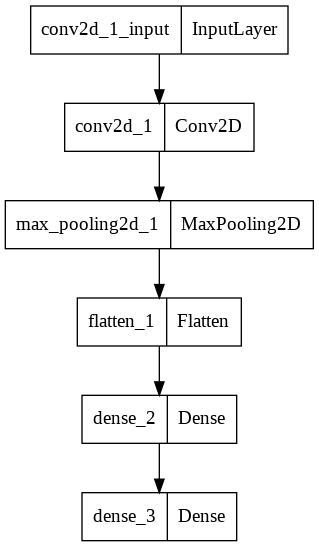

In [25]:
base_model_structure = os.path.join(MODEL_DIR, 'base_model.png')
plot_model(model, to_file=base_model_structure)

In [26]:
train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]

In [27]:
sampling_times = 10
nsamples = 200
level = 5
factor = 2 ** level
val_split = 0.3

In [28]:
train_loss_lst = []
train_accuracy_lst = []
val_loss_lst = []
val_accuracy_lst = []

In [12]:
for s_i in range(sampling_times):

  for slide_num in train_file:
    print("\nStart Processing for", slide_num)
    
    slide_image = read_full_image(slide_num, level=level, ifmask=False)
    mask_image = read_full_image(slide_num, level=level, ifmask=True)

    # Generate samples and train model
    neg_i = 0

    print("Sampling", s_i)
    start_ind = s_i * nsamples
    end_ind = (s_i+1) * nsamples

    # positive samples
    print("Generating positive samples......")
    pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(pos_file):
      print(f"{pos_file} not exists!!!")
    else:
      print("------Load samples-------")
      pos_pitch_lst = np.load(pos_file)[0]

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (pos_pitch_lst[int(val_split*nsamples) :], 
          np.array([1.0] * nsamples)[int(val_split*nsamples) :])
        )
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (pos_pitch_lst[: int(val_split*nsamples)], 
          np.array([1.0] * nsamples)[: int(val_split*nsamples)])
        )

    del pos_pitch_lst
    gc.collect()
    

    # negative samples
    print("Generating negative samples......")
    neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

    if not os.path.exists(neg_file):
      print(f"{pos_file} not exists!!!")
    else:
      print("------Load samples-------")
      neg_pitch_lst = np.load(neg_file)[0]

    train_dataset = train_dataset.concatenate(
        tf.data.Dataset.from_tensor_slices(
            (neg_pitch_lst[int(val_split*nsamples) :], 
              np.array([0.0] * nsamples)[int(val_split*nsamples) :])
          )
        )
    
    val_dataset = val_dataset.concatenate(
        tf.data.Dataset.from_tensor_slices(
            (neg_pitch_lst[: int(val_split*nsamples)], 
              np.array([0.0] * nsamples)[: int(val_split*nsamples)])
          )
        )
    
    del neg_pitch_lst
    gc.collect()

    # Prepare dataset
    print("Prepare dataset......")
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = int(nsamples*2*(1-val_split))
    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = int(nsamples*2*val_split)
    val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

    print("Train model......")
    checkpoint_path = os.path.join(MODEL_DIR, "model_5_200.ckpt")
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, save_weights_only=True, verbose=1)
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[cp_callback])

    train_loss_lst.extend(history.history["loss"])
    train_accuracy_lst.extend(history.history["binary_accuracy"])
    val_loss_lst.extend(history.history["val_loss"])
    val_accuracy_lst.extend(history.history["val_binary_accuracy"])

    res_df = pd.DataFrame({
        "train_loss_lst": train_loss_lst,
        "train_accuracy_lst": train_accuracy_lst,
        "val_loss_lst": val_loss_lst,
        "val_accuracy_lst": val_accuracy_lst
    })
    res_file = os.path.join(RES_DIR, "res_5_200.csv")
    res_df.to_csv(res_file, index=False)




Start Processing for 101
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 4352, height: 2240
Sampling 0
Generating positive samples......
------Load samples-------
Generating negative samples......
------Load samples-------
Prepare dataset......
Train model......
Epoch 1/2
5/5 [==============================] - ETA: 0s - loss: 9.0241 - binary_accuracy: 0.4964
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/ADL/project/model/model_5_200.ckpt
5/5 [==============================] - 10s 322ms/step - loss: 9.0241 - binary_accuracy: 0.4964 - val_loss: 8.0405 - val_binary_accuracy: 0.5000
Epoch 2/2
4/5 [=======================>......] - ETA: 0s - loss: 6.0589 - binary_accuracy: 0.5703
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/ADL/project/model/model_5_200.ckpt
5/5 [=

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [14]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_loss_lst", "val_loss_lst"], 
    markers=True)
fig.show()

In [15]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_accuracy_lst", "val_accuracy_lst"], 
    markers=True)
fig.show()

In [29]:
checkpoint_path = os.path.join(MODEL_DIR, "model_5_200.ckpt")
# Loads the weights
model.load_weights(checkpoint_path)

In [30]:
def label_prediction(x, y, predict_mask, label=1.0, patch_len=299, target_size=128):
  offset = (patch_len - target_size)//2
  x_target = x + offset
  y_target = y + offset

  target_area = predict_mask[x_target: x_target+target_size, y_target: y_target+target_size]
  assert target_area.shape[0] == target_size

  predict_mask[x_target: x_target+target_size, y_target: y_target+target_size] = label

  return predict_mask

In [36]:
def label_heatmap_onezoom(
    slide_image, mask_image, predict_mask,
    level=5, threshold=0.5, step=10, patch_len=299, 
    show_res=True, verbose=0):

  predict_mask = np.zeros(mask_image.shape, dtype=float)

  x_scan = 0
  while x_scan <= slide_image.shape[0] - patch_len:
    
    y_scan = 0
    while y_scan <= slide_image.shape[1] - patch_len:
      
      xc_0, yc_0 = get_center(slide_image, x_scan, y_scan, level=level)

      factor = 2 ** level
      xc_level = xc_0 // factor
      yc_level = yc_0 // factor
      x_level = xc_level - patch_len//2
      y_level = yc_level - patch_len//2

      assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
      assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
      assert 0 <= x_level <= slide_image.shape[0]
      assert 0 <= y_level <= slide_image.shape[1]

      tumor_region = get_patch_from_center(slide_image, xc_0, yc_0, level=level)
      
      if delete_gray(tumor_region):
        check_image = get_patch_from_center(mask_image, xc_0, yc_0, level=level)
        label = get_target(check_image)

        tumor_region = tumor_region / 255.0
        
        pred = model.predict(np.array([tumor_region]), verbose=verbose)
        pred_label = (pred > threshold).astype("int32")

        if show_res:
          check_image = get_patch_from_center(mask_image, xc_0, yc_0, level=level)
          label = get_target(check_image)
          if label == 1:
            print(label, pred)

        if pred_label[0][0] == 1:
          predict_mask = label_prediction(x_scan, y_scan, predict_mask, label=1)
        else:
          predict_mask = label_prediction(x_level, y_level, predict_mask, label=0)

      y_scan += step
    x_scan += step
  
  return predict_mask


In [37]:
train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]


Label heatmap for 091
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 1920, height: 1680
The shape of predict_mask (1680, 1920)
The number of tumor of predict_mask 0.0
The number of tumor of predict_mask after labeling 1618960.0


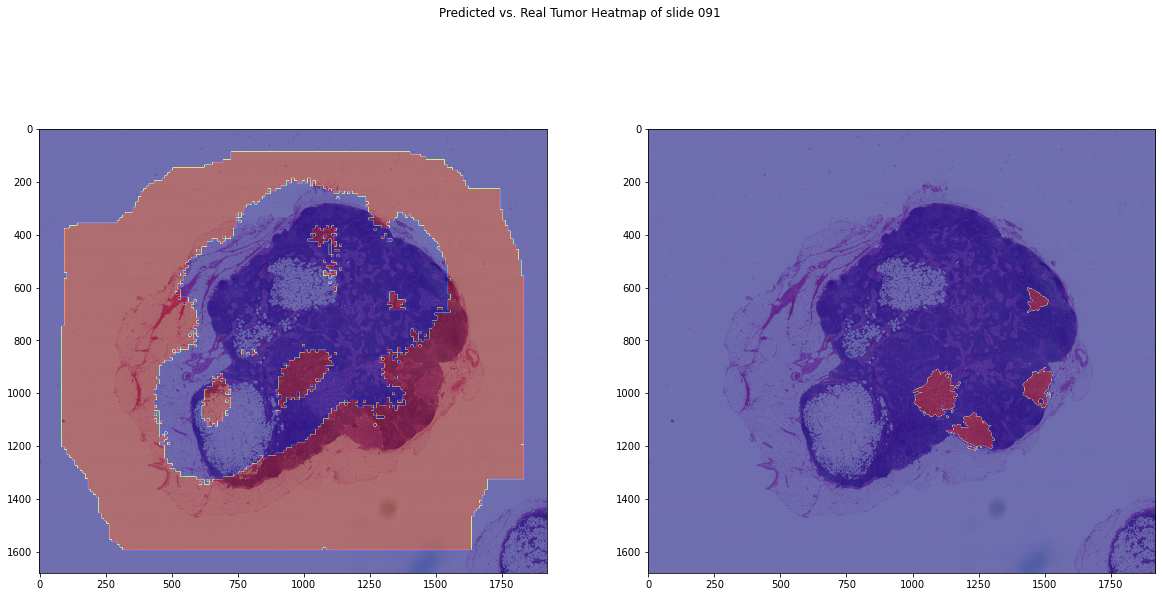


Label heatmap for 075
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 2816, height: 2464
The shape of predict_mask (2464, 2816)
The number of tumor of predict_mask 0.0
The number of tumor of predict_mask after labeling 4308480.0


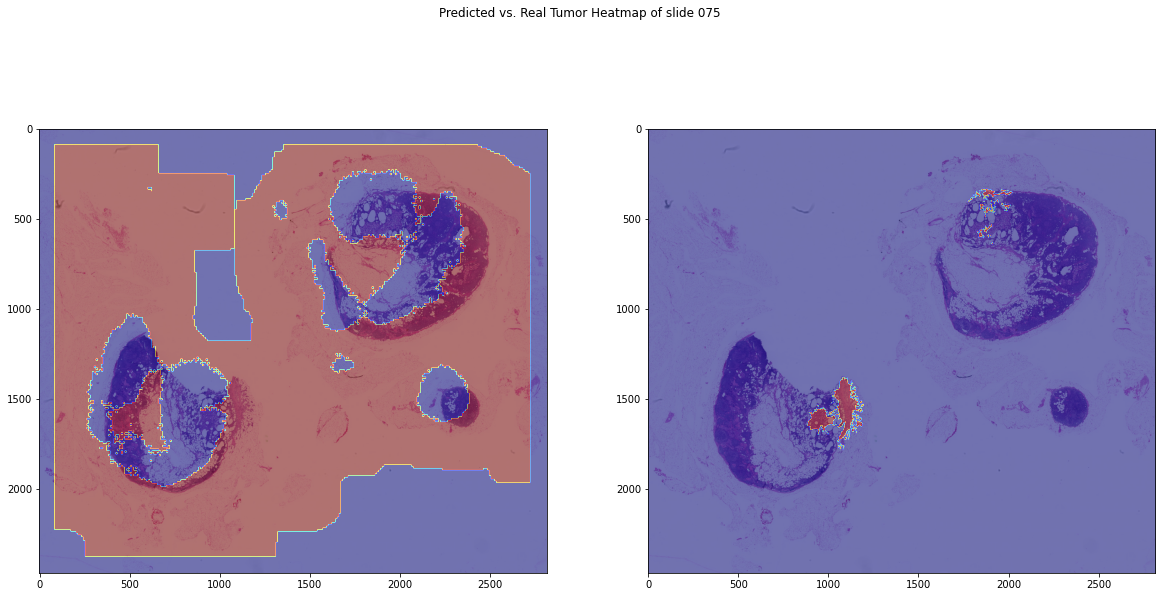


Label heatmap for 094
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 3712, height: 3136
The shape of predict_mask (3136, 3712)
The number of tumor of predict_mask 0.0
The number of tumor of predict_mask after labeling 8014740.0


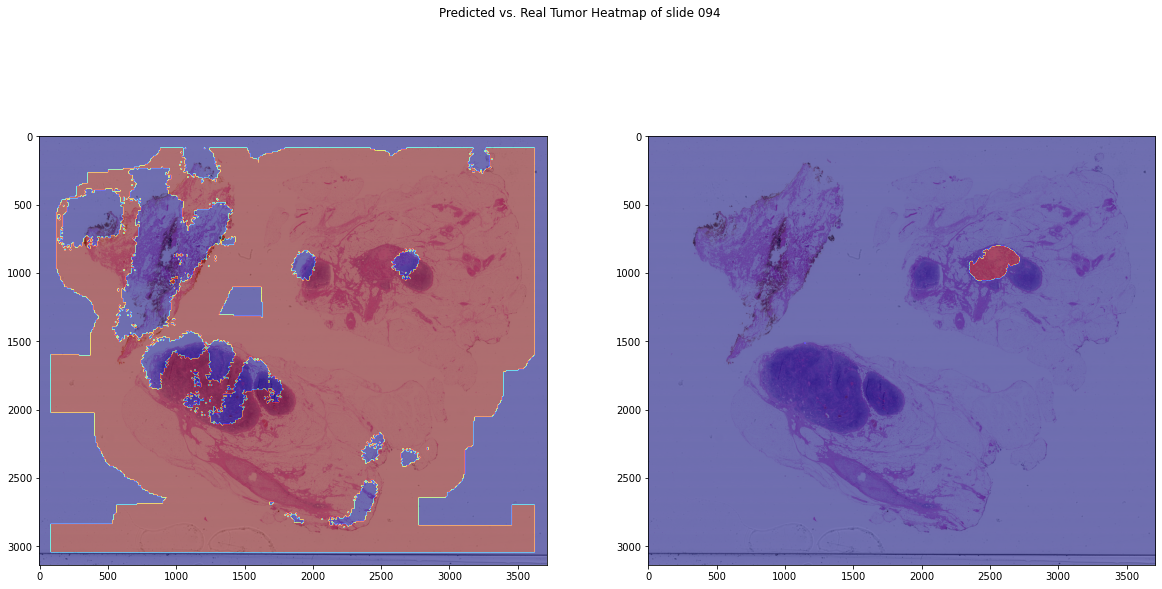


Label heatmap for 084
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 2048, height: 2688
The shape of predict_mask (2688, 2048)
The number of tumor of predict_mask 0.0
The number of tumor of predict_mask after labeling 2873944.0


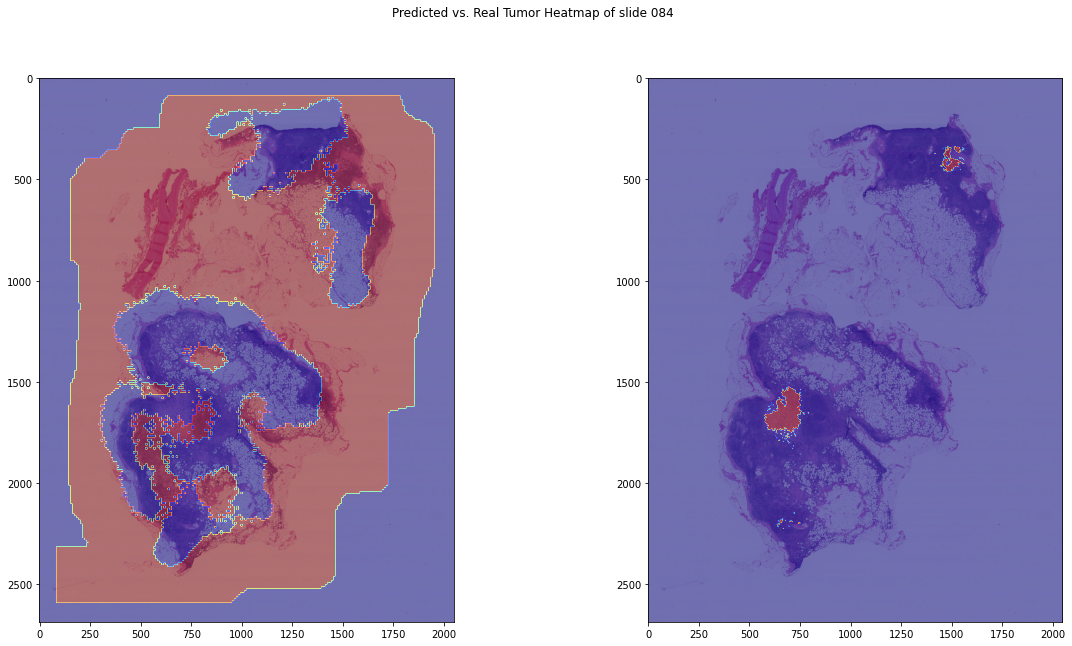

In [39]:
for slide_num in test_file:
  print("\nLabel heatmap for", slide_num)
  
  level = 5
  slide_image = read_full_image(slide_num, level=level, ifmask=False)
  mask_image = read_full_image(slide_num, level=level, ifmask=True)

  predict_mask = np.zeros(mask_image.shape, dtype=float)
  print("The shape of predict_mask", predict_mask.shape)
  print("The number of tumor of predict_mask", predict_mask.sum())

  predict_mask = label_heatmap_onezoom(
      slide_image, mask_image, predict_mask, level=5,
      threshold=0.5, step=10, patch_len=299, 
      show_res=False, verbose=0)
  print("The number of tumor of predict_mask after labeling", predict_mask.sum())
  
  f, axarr = plt.subplots(1,2) 
  f.set_figheight(10)
  f.set_figwidth(20)
  f.suptitle(f'Predicted vs. Real Tumor Heatmap of slide {slide_num}')
  axarr[0].imshow(slide_image)
  axarr[0].imshow(predict_mask, cmap='jet', alpha=0.5)
  axarr[1].imshow(slide_image)
  axarr[1].imshow(mask_image, cmap='jet', alpha=0.5)
  plt.show()

In [ ]:
# predict_mask = np.zeros(mask_image.shape, dtype=float)
# patch_len = 299
# level = 5

# x_scan = 0

# while x_scan <= slide_image.shape[0] - patch_len:
  
#   y_scan = 0
  
#   while y_scan <= slide_image.shape[1] - patch_len:
    
#     xc_0, yc_0 = get_center(slide_image, x_scan, y_scan, level=level)
#     region = get_patch_from_center(slide_image, xc_0, yc_0, level=level)
    
#     if delete_gray(region):
#       mask_region = get_patch_from_center(mask_image, xc_0, yc_0, level=level)
#       label = get_target(mask_region)

#       region = region / 255.0
#       pred = model.predict(np.array([region]))
#       pred_label = (pred > 0.9).astype("int32")

#       if label == 1:
#         print(label, pred)

#       if pred_label[0][0] == 1:
#         predict_mask = label_prediction(x_scan, y_scan, predict_mask)

#     y_scan += step

#   x_scan += step


1/1 [==============================] - 0s 16ms/step
1.0 [[0.04195857]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.01438776]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.91701484]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.02836809]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.9170939]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.0045849]]
1/1 [==============================] - 0s 14ms/step
1.0 [[0.01156549]]
1/1 [==============================] - 0s 17ms/step
1.0 [[0.9286853]]
1/1 [==============================] - 0s 16ms/step
1.0 [[0.34034756]]
1/1 [==============================] - 0s 14ms/step
1.0 [[0.81325006]]
1/1 [==============================] - 0s 14ms/step
1.0 [[0.9702813]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.99238443]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.98756766]]
1/1 [==============================] - 0s 15ms/step
1.0 [[0.96520287]]
1/1 [=====

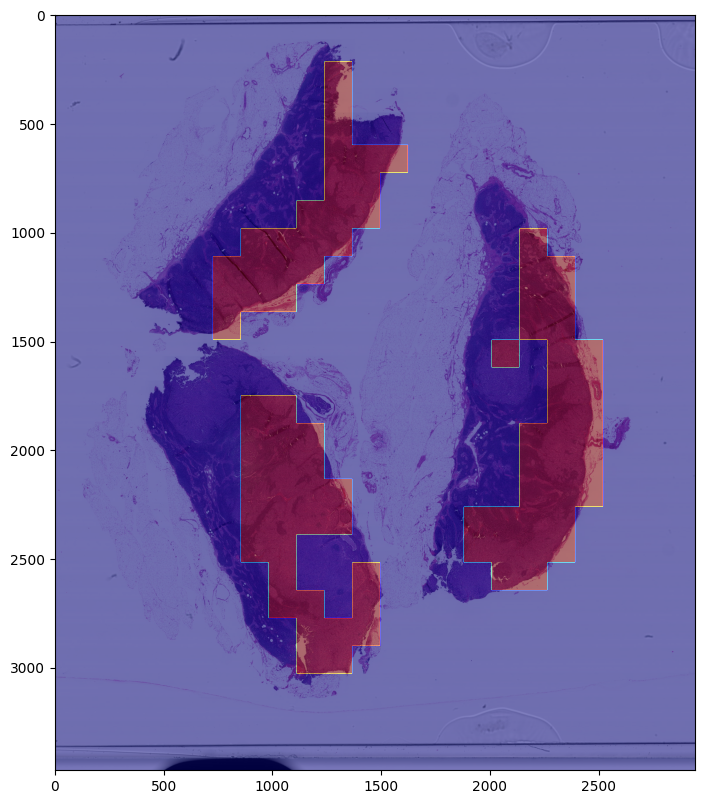

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(predict_mask, cmap='jet', alpha=0.5) # Red regions contains cancer.

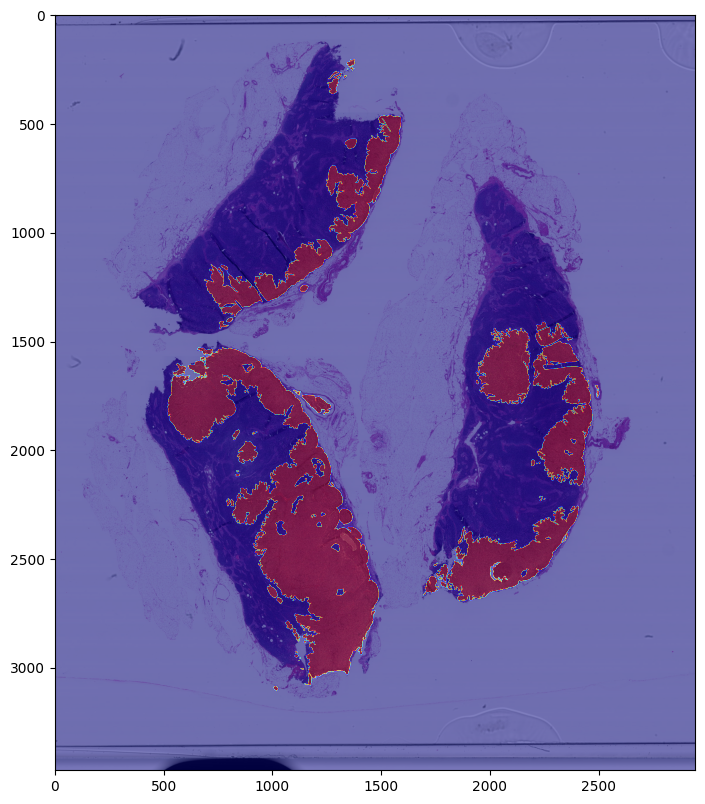

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.